In [29]:
# Initialize Otter
import otter
grader = otter.Notebook("lab05_two_mode_networks.ipynb")

In [30]:
!pip install --upgrade networkx

In [31]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')


import os
import networkx as nx
from networkx.algorithms import bipartite

import warnings
warnings.filterwarnings('ignore')

## Lab - Two Mode networks and bipartite graphs

Today, we're going to study *two-mode networks*, sometimes called affiliation networks or bipartite networks. These networks are composed of relationships between two different types of nodes. Some common examples:

* people who attend events
* people who belong to groups

Two-mode networks can be represented by *bipartite graphs*. Bipartite graphs are like other mathematical graphs, but they have an additional property: the nodes in the graph can be divided into two sets, say A and B, such that every edge in the graph connects a node from A to a node from B. 

In addition to two-mode networks, some other types of networks that can be represented as bipartite graphs are:

* people who work together on a project (such as a scientific paper or a movie)
* people who buy a product
* people who read an article

These networks are different from what we have seen before because there are really two types of nodes: one type of node is a person, but another type of node is an event / group / product / etc.

### Example: birthday parties

Here is an example of an two-mode network (from pg 299 of *Social Network Analysis* by Wasserman and Faust):

<img src="affiliation_example_wassermanfaust.png">

Let's enter this graph into networkx using an edge list:

In [32]:
bday_net = nx.Graph([('A', '1'), ('A', '3'), ('D', '2'), ('E', '2'), ('E', '3'), ('K', '3'), ('R', '1'), ('R', '2'), ('R', '3'), ('S', '1'), ('S', '2')])

We have to do a bit of extra work to tell `networkx` that this graph is bipartite. We'll pass the names of the nodes in one of the bipartite sets like so:

In [33]:
bday_child_nodes = ['A', 'D', 'E', 'K', 'R', 'S']
bday_party_nodes = ['1', '2', '3']

#bday_net = nx.Graph()

# bipartite=0 tells networkx that these nodes are one of the independent sets of the bipartite network;
bday_net.add_nodes_from(bday_child_nodes, bipartite=0)
# the other independent set will have bipartite=1
bday_net.add_nodes_from(bday_party_nodes, bipartite=1)

We can double-check that we've created a two-mode network (also called a bipartite network, if you recall) with `nx.is_bipartite`:

In [34]:
nx.is_bipartite(bday_net)

True

And we can have `networkx` draw it -- but we'll have to jump through a couple of hoops to force networkx to put one independent set of nodes on the left and the other independent set of nodes on the right:

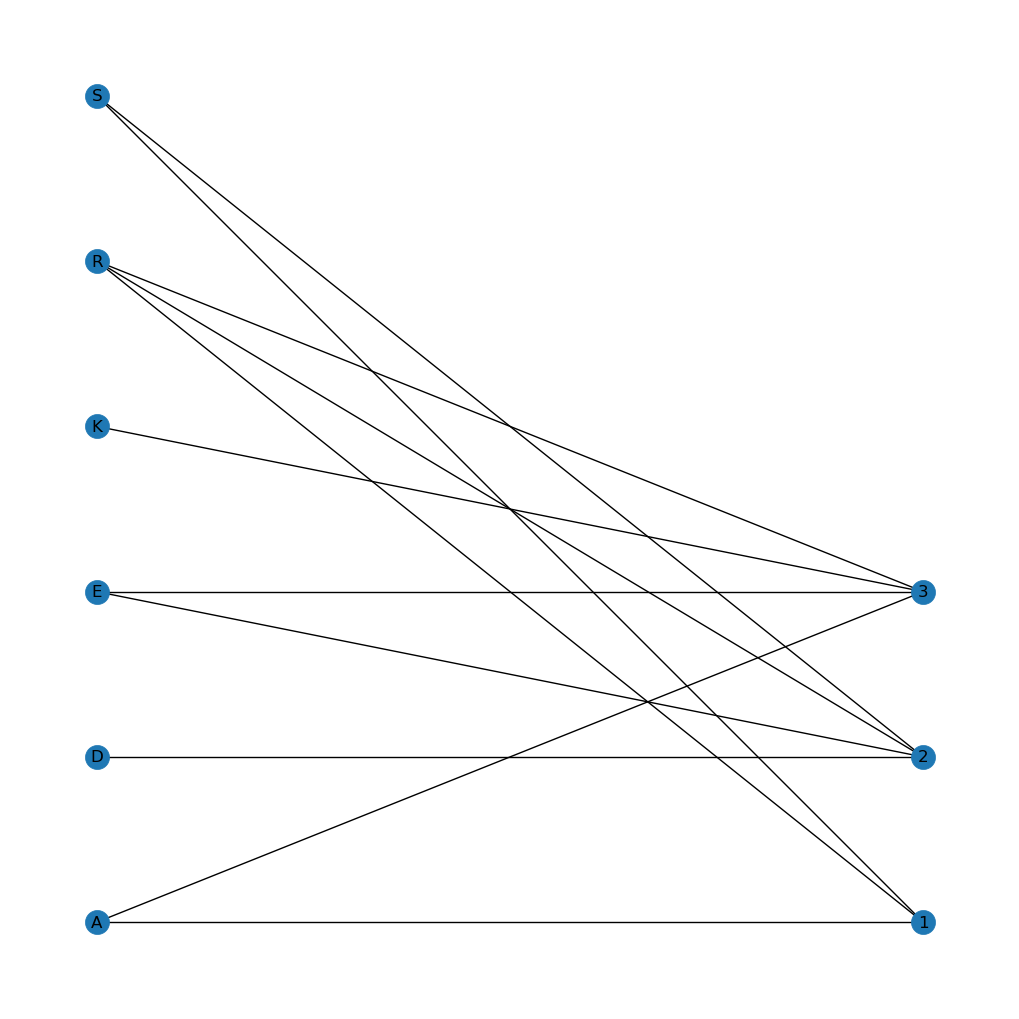

In [35]:
bday_pos = dict()

for idx, node_id in enumerate(bday_child_nodes):
    bday_pos[node_id] = (1, idx)
    
for idx, node_id in enumerate(bday_party_nodes):
    bday_pos[node_id] = (2, idx)

plt.figure(figsize=(10,10))
nx.draw(bday_net, pos=bday_pos, with_labels=True)

In order to get information about the degrees of each half of the network, we can give the `nx.degree` function a list of node ids. The result is a dictionary-like object, but to get just a list of the degrees themselves,
we must cast to a `dict()` and then use `.values()` to extract. All in all, this is a pattern for getting the degrees in each independent set:

In [36]:
nx.degree(bday_net, bday_child_nodes)

DegreeView({'A': 2, 'D': 1, 'E': 2, 'K': 1, 'R': 3, 'S': 2})

In [37]:
child_degrees = dict(nx.degree(bday_net, bday_child_nodes)).values()
party_degrees = dict(nx.degree(bday_net, bday_party_nodes)).values()

print(child_degrees)
print(party_degrees)

dict_values([2, 1, 2, 1, 3, 2])
dict_values([3, 4, 4])


Many functions in the networkx package will let you pass in a list of node ids like nx.degree does.

### Example: average clustering

To illustrate how two-mode networks are somewhat different from the other networks we have seen so far, we'll use the concept of network *average clustering*. We discussed this in a previous lab; conceptually, the clustering coefficient of an individual node captures the extent to which that nodes friends are friends with each other. The average clustering of a network is the average of the clustering coefficient over all of the individual nodes.

In a one-mode network (like all of the ones we have seen before today), the clustering coefficient can be calculated like this:

$$C(v) = \frac{\# \text{ edges between node $v$'s friends}}{\# \text{ max possible edges between node $v$'s friends}}$$

This is problematic in the case of a bipartite network. Can you see why?

[Latapy et al](http://www.sciencedirect.com/science/article/pii/S0378873307000494) have proposed an alternative metric for clustering in a bipartite graph. First, they define a metric for overlap; for any pair of nodes $u$ and $v$ that are in the same independent set,

$$overlap(u, v) = \frac{\# \text{ neighbors u and v share}}{\# \text{max neighbors u and v could share}}$$

At most, this value is $1$ (when both nodes have exactly the same set of neighbors); at least, this value is $0$ (when the two nodes have no neighbors in common).

The bipartite clustering coefficient for one node $u$ is then defined to be

$$C_{b}(u) = \frac{\text{sum of overlap between $u$ and all other nodes that are 2 steps away from $u$}}{\# \text{ nodes that are 2 steps away from u}}$$

The average bipartite clustering coefficient is then the average of this quantity over all of the nodes in the network. This quantity will range from 0 (no clustering) to 1 (perfect clustering).

We don't need to dwell on how this metric is constructed; for our purposes today, there are two important lessons:

* network metrics like clustering can't necessarily be meaningfully used in two-mode networks
* but it is often possible to come up with a metric that gets at the same idea

### Bipartite projections

Two-mode bipartite networks can be transformed into one-mode networks by *projecting* them. In the example above, we could create a network whose nodes are children, where two children are connected by an edge if they attended the same birthday party.

<!-- BEGIN QUESTION -->

# Question 1:

What are the edges in the one-mode projection of the birthday party affiliation network onto the child nodes? (You can write out the edge list.)

_AR, AS, AK, DE, DR, DS, ER, ES, EA, EK, KR, RS_

<!-- END QUESTION -->

# Question 2:

Use the `networkx` function `bipartite.projected_graph` to check your answer

In [38]:
bday_child_net = nx.bipartite.projected_graph(bday_net, bday_child_nodes)
bday_child_net.edges()

EdgeView([('A', 'S'), ('A', 'K'), ('A', 'E'), ('A', 'R'), ('D', 'S'), ('D', 'E'), ('D', 'R'), ('E', 'S'), ('E', 'R'), ('E', 'K'), ('K', 'R'), ('R', 'S')])

In [39]:
grader.check("q2")

q2 results: All test cases passed!

Let's visualize this projected network:

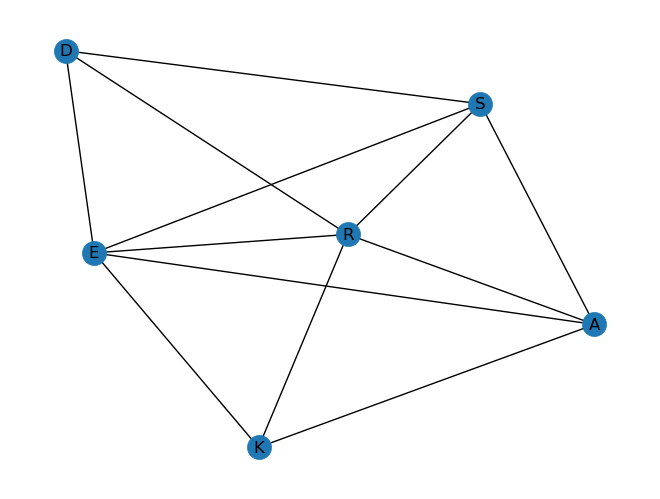

In [40]:
nx.draw(bday_child_net, with_labels=True)

Creating the projected network threw away a lot of information; for example, two children who both attended the exact same set of parties can't be distinguished from two children who just attended one same party. (Be sure you see why.)


One way to keep more information about the structure in the bipartite network is to weight the edges in the projected network (ie, assign them numerical values). What should the weights be? Well, that depends; there are lots of options, and it generally makes sense to use what you know about the substantive problem you are working on to figure out what the best way to generate weights is. Here, we'll start with a very simple procedure: we will weight the edge by the number of events that the two nodes co-attended.

<!-- BEGIN QUESTION -->

# Question 3:

Add weights to the edges of the projected network that you made above (the one you made by hand).
Example: `('A', 'E', {'weight' : 1})`

_AR (1), AS (1), AK (1), DE (1), DR (1), DS (1), ER (2), ES (1), EA (1), EK (1), KR (1), RS (2)_

<!-- END QUESTION -->


# Question 4:

The `networkx` function `bipartite.weighted_projected_graph` will calculate this weighted projected network for you. Use it to check your work.

In [41]:
bday_child_net2 = nx.bipartite.weighted_projected_graph(bday_net, bday_child_nodes)
bday_child_net2.edges(data=True)

EdgeDataView([('A', 'S', {'weight': 1}), ('A', 'K', {'weight': 1}), ('A', 'E', {'weight': 1}), ('A', 'R', {'weight': 2}), ('D', 'S', {'weight': 1}), ('D', 'E', {'weight': 1}), ('D', 'R', {'weight': 1}), ('E', 'S', {'weight': 1}), ('E', 'R', {'weight': 2}), ('E', 'K', {'weight': 1}), ('K', 'R', {'weight': 1}), ('R', 'S', {'weight': 2})])

# Projected networks and thresholding

Finally, we're going to look at different ways to construct a projected network from a two-mode network.

### The Southern Women dataset

Below is an example of a famous two-mode network originally collected by Davis and colleagues (Davis, Gardner and Gardner, 1941, *Deep South: A Social Anthropological Study of Caste and Class*).  The rows of the matrix below correspond to eighteen women in a southern town, while the columns correspond to 14 different social events. An entry in the matrix is 1 if the corresponding woman attended the corresponding event, and 0 otherwise.

<img src="southern_women_matrix_breiger1974.png">

The Koblenz Network Collection has [digitized](http://konect.uni-koblenz.de/networks/opsahl-southernwomen) this network; we'll read it in now.

In [42]:
sw_dat = []
with open(os.path.join("data", "southern-women", "southernwomen.tsv")) as f:
    for line in f:
        # lines beginning with '%' are comments
        if line[0] == '%':
            continue
        sw_dat.append(line.strip())

# by default, the nodes are just numbers; we'll make them more descriptive
# to avoid confusion later on in our analysis
sw_edges = [(("woman_" + (str.split(x)[0])), ("event_" + (str.split(x)[1]))) for x in sw_dat]

all_women = list(set(x[0] for x in sw_edges))
all_events = list(set(x[1] for x in sw_edges))

Similar to the process we used with the birthday party attendance, above, we'll create a bipartite `networkx` graph using the edgelist and information about which node is in which independent set.

In [43]:
sw_net = nx.Graph()
sw_net.add_nodes_from(all_women, bipartite=0)
sw_net.add_nodes_from(all_events, bipartite=1)
sw_net.add_edges_from(sw_edges)

# Question 5

Draw the network using a non-bipartite method (like `nx.draw_spring`, for example). Is it easy to tell that this network is bipartite from the picture?

_Type your answer here, replacing this text._

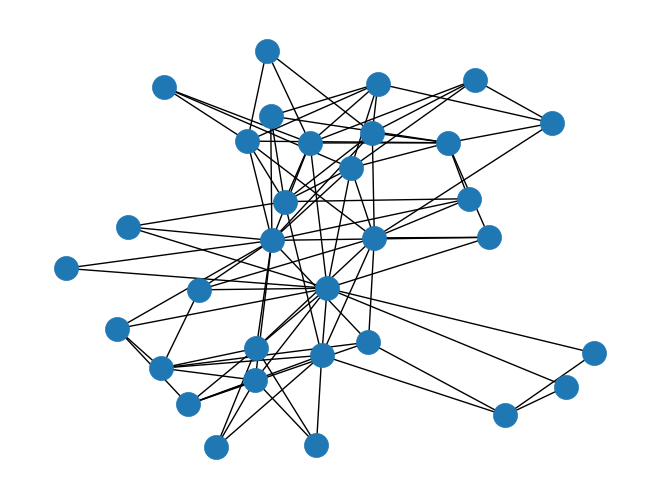

In [44]:
nx.draw_spring(sw_net)

In [45]:
grader.check("q5")

q5 results: All test cases passed!

# Question 6

Now plot this network explicitly accounting for the bipartite structure: adapt the code above to be sure that all of the nodes representing women are on the left and all of the nodes representing events are on the right.

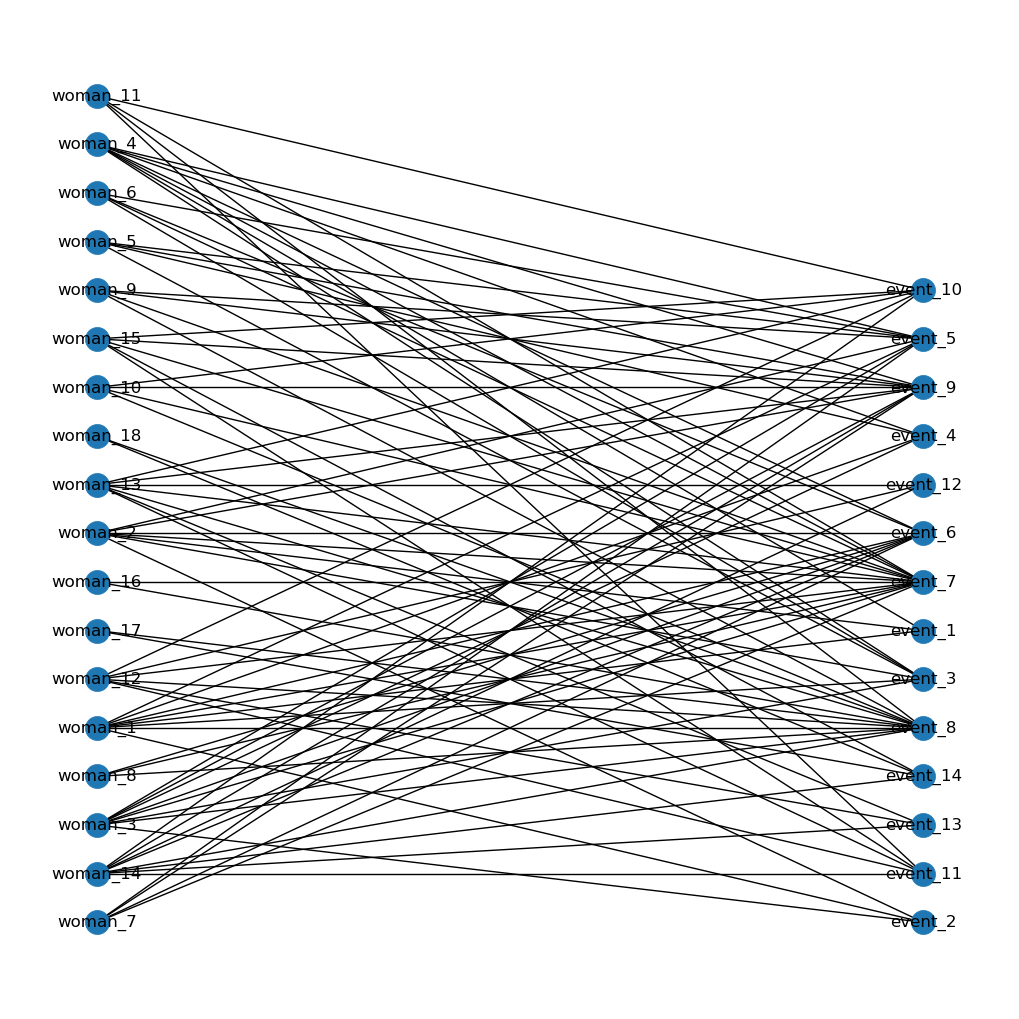

In [46]:
sw_pos = dict()

for idx, node_id in enumerate(all_women):
    sw_pos[node_id] = (1, idx) 
    
for idx, node_id in enumerate(all_events):
    sw_pos[node_id] = (2, idx) 

plt.figure(figsize=(10,10))
nx.draw(
    G=sw_net, 
    pos=sw_pos, 
    with_labels=True) 

In [47]:
grader.check("q6")

q6 results: All test cases passed!

# Question 7

Project the Southern Women's network onto the nodes that are women (Hint: look at the function `bipartite.projected_graph`).

Plot the network and make a histogram of the distribution of degrees (using the `nx.degree` function and `plt.hist`. Hint: see the example in the introduction for how to extract degrees from `nx.Graph` objects).

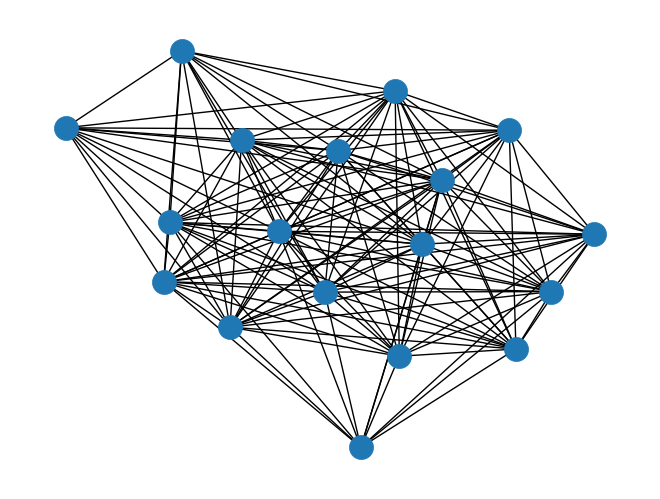

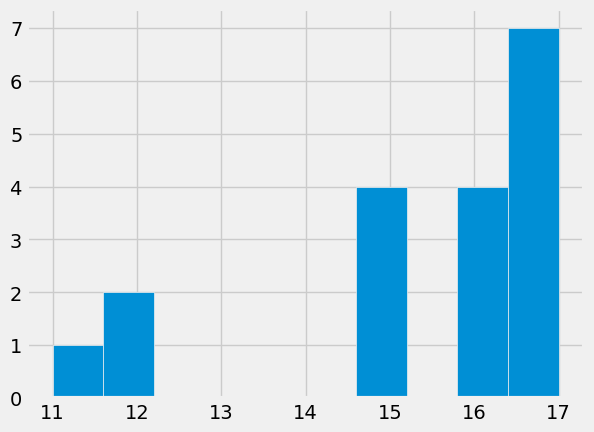

In [48]:
women_network = bipartite.projected_graph(sw_net, all_women) 
nx.draw(women_network)
plt.show()
plt.hist(dict(nx.degree(women_network)).values())
plt.show()

In [49]:
grader.check("q7")

q7 results: All test cases passed!

This network is very highly connected; in fact, it is so highly connected that it is almost uninformative -- basically, the women are all connected to each other.  One way to try and improve the insights we can obtain from a projected network is to keep more information by weighting the edges.

Project the Southern Women network onto the nodes that are women, weighting each resulting edge by the number of events that were co-attended. *[Hint: look up the function `bipartite.weighted_projected_graph`]*.

In [50]:
women_network_weighted = bipartite.weighted_projected_graph(sw_net, all_women)

In many cases, it is possible to work directly with a weighted network. In others, it is convenient to turn the weighted network into an unweighted one.  We can turn a weighted network into an unweighted one by picking a threshold above which we will consider two nodes connected.

Here is a function which takes a network with weighted edges and a threshold. It returns a new network that has all edges whose weight is less than the threshold removed. Check it out:

In [51]:
def edge_threshold(net, threshold):
    
    # we'll make a copy of this network so that we don't
    # change the original
    new_net = net.copy()
    
    for e in new_net.edges():
        if new_net[e[0]][e[1]]['weight'] < threshold:
            new_net.remove_edge(e[0], e[1])
    
    return(new_net)

# Question 8:
The loop below is supposed to go through all of the possible threshold values from 1 to 14 and draw the network that results when we only count edges above that threshold. Fill in the missing parts and look at the results:

_Type your answer here, replacing this text._

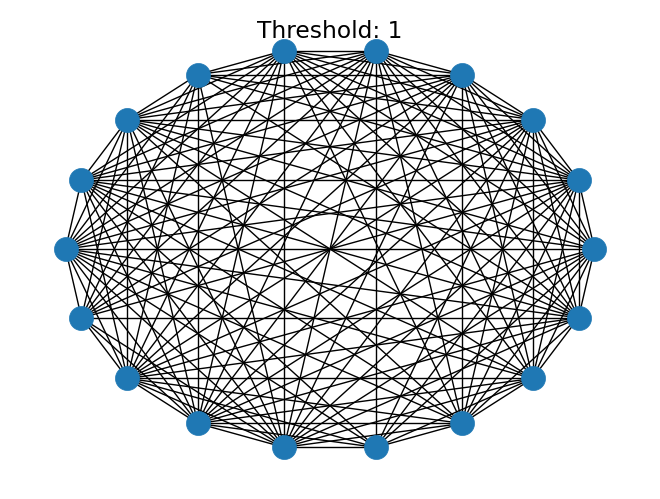

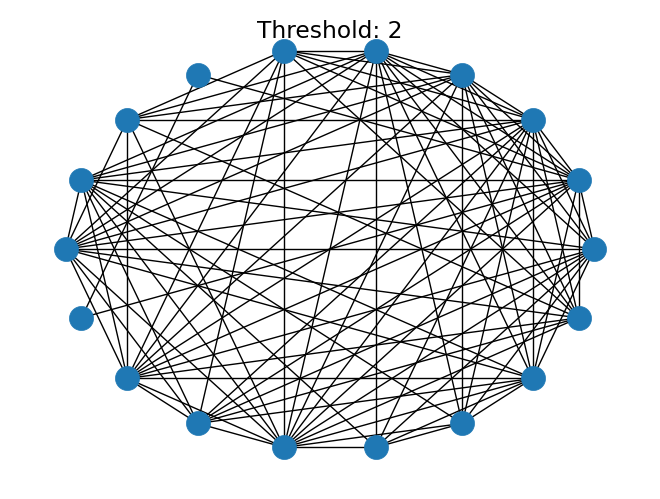

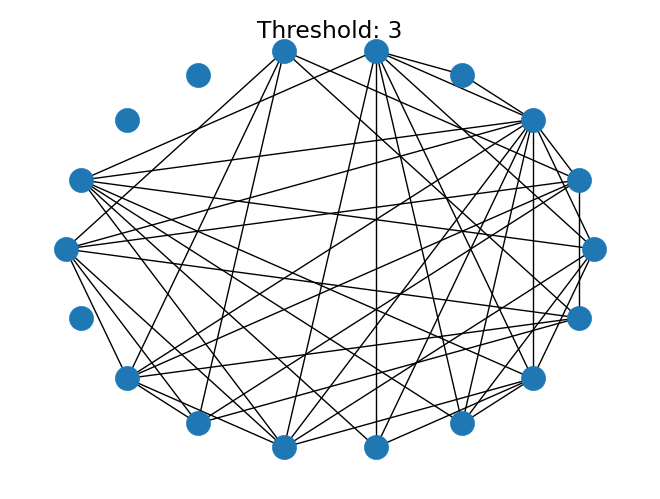

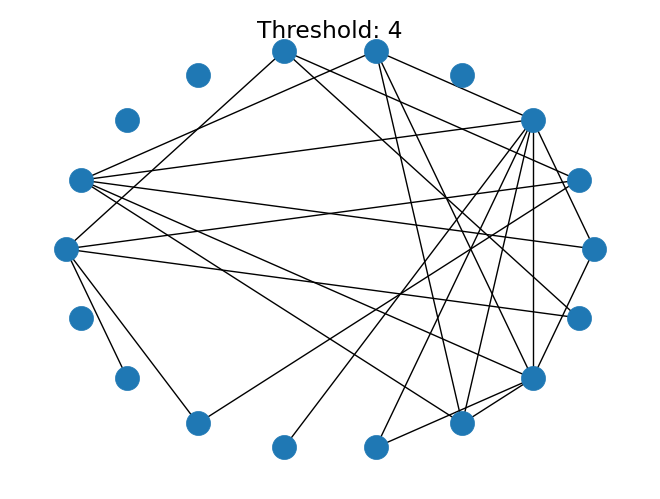

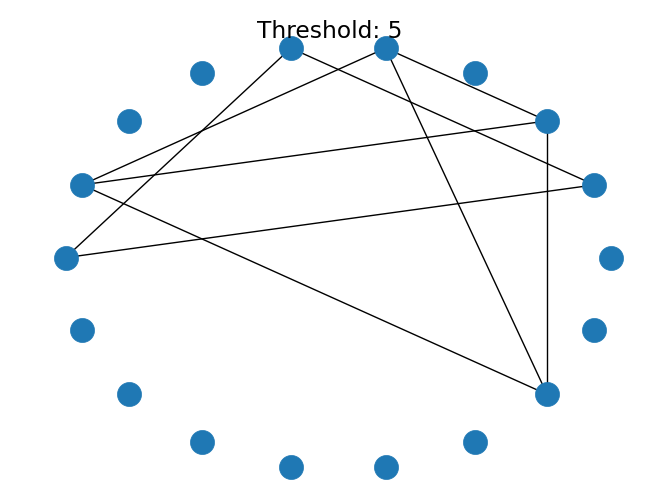

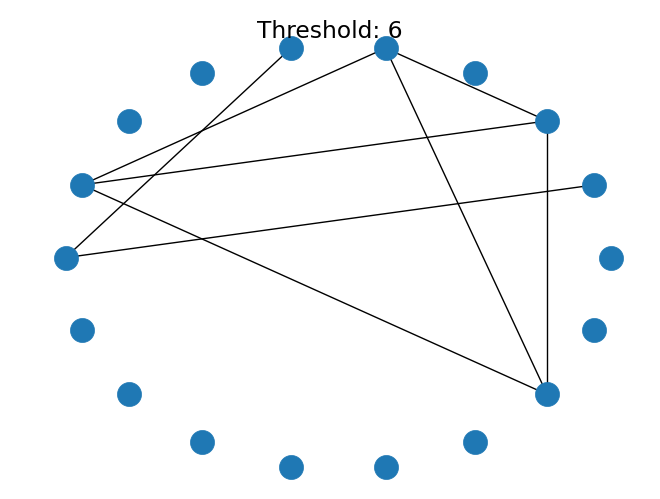

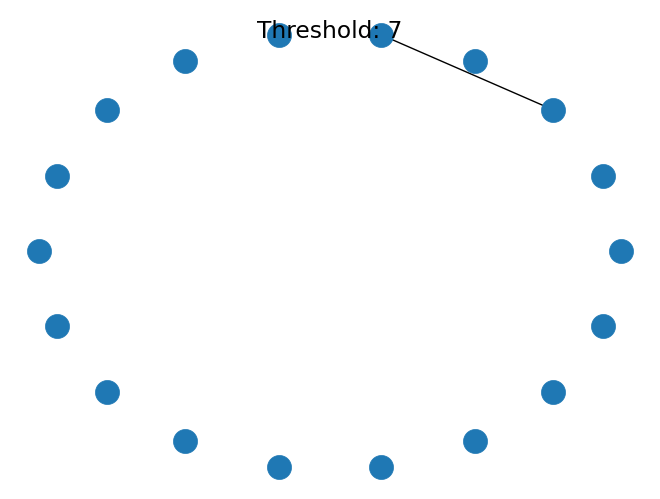

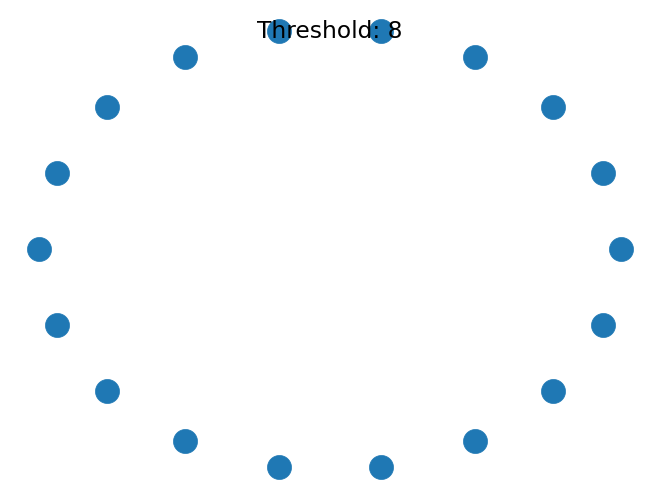

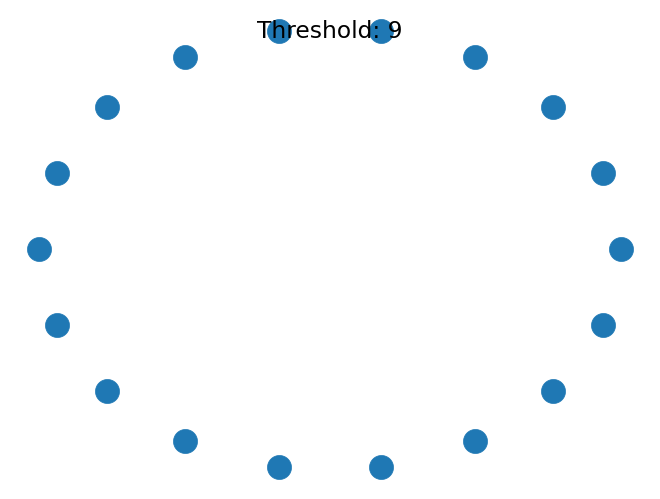

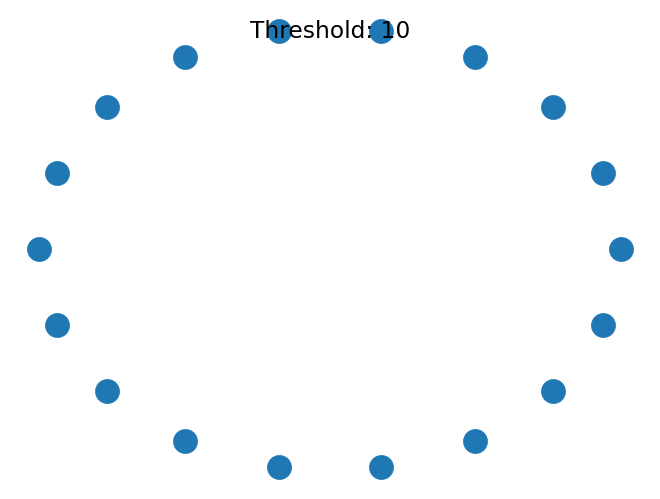

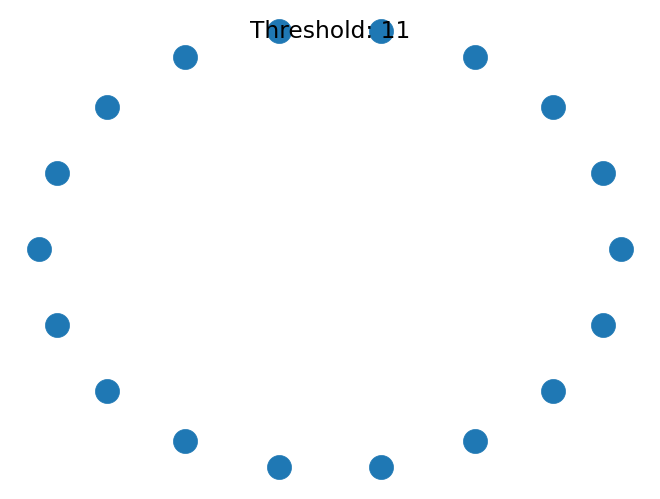

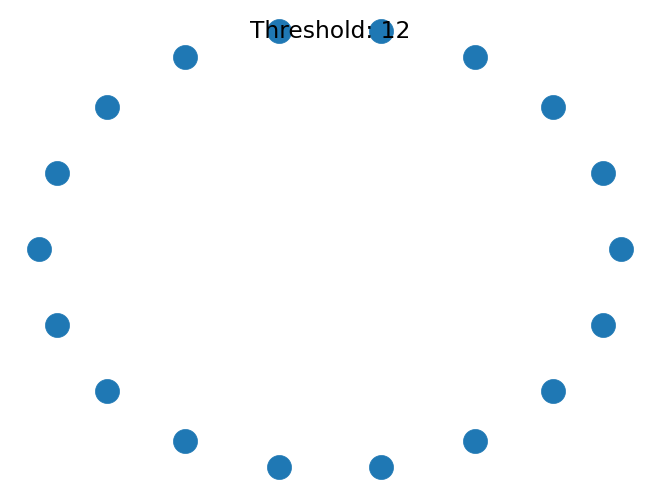

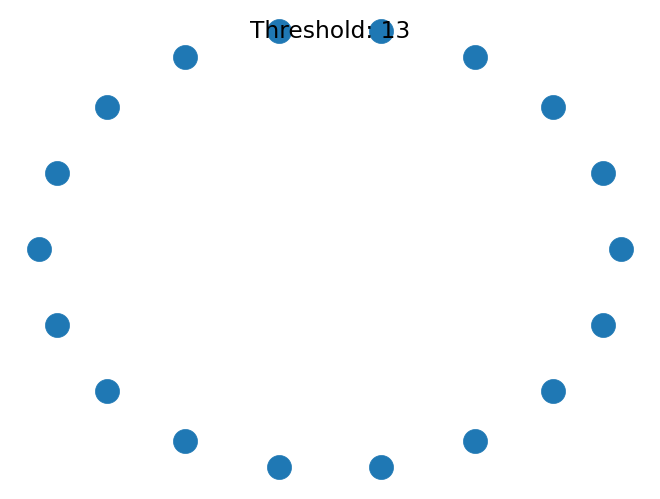

In [52]:
for thresh in range(1 , 1):
    this_net = edge_threshold(women_network_weighted, thresh)
    plt.figure()
    plt.suptitle("Threshold: " + str(thresh))
    nx.draw_circular(this_net)

In [53]:
grader.check("q8")

q8 results: All test cases passed!

<!-- BEGIN QUESTION -->

# Question 9:
If you were a researcher studying the Southern Women's network, which threshholds would be most informative for you? Why?

_I would think some of the middle thresholds would be the most interesting, around values 3 to 7. These seem more useful as the graph is so full that almost every connection exists, but there are also still edges there that can be analyzed for information._

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [54]:
grader.check_all()

q2 results: All test cases passed!

q5 results: All test cases passed!

q6 results: All test cases passed!

q7 results: All test cases passed!

q8 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the .zip file to Gradescope.

In [55]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...



Your submission received the following results when run against available test cases:

    q2 results: All test cases passed!

    q5 results: All test cases passed!

    q6 results: All test cases passed!

    q7 results: All test cases passed!

    q8 results: All test cases passed!
